In [1]:
import math
import random

import numpy as np
from numba import njit, prange
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
@njit(fastmath=True)
def reduce_density(points: np.ndarray, sep_factor: float, niter: int):
    for k in prange(niter):
        forces = np.zeros(points.shape)
        for i in prange(points.shape[0]):
            force_i = np.zeros(points.shape[1], dtype=float)
            for j in range(points.shape[0]):
                d = np.linalg.norm(points[i]-points[j])
                force_i += np.exp(-sep_factor*d)*(points[i]-points[j])
            forces[i] = force_i
        points += forces

In [258]:
@njit(fastmath=True)
def find_winner(p: np.ndarray, x: np.ndarray):
    return np.argmin(np.array([np.sum(np.square(x-w)) for w in p], dtype='float'))


@njit(fastmath=True)
def update_weight(x: np.ndarray, p: np.ndarray, c: int, a: float, b: float, t: int) -> np.ndarray:
    d = np.sum(np.square(p-p[c]), axis=1)
    s = np.exp(-b*d*t)
    return a*s.reshape((s.size, 1))*(x-p)


class SOM:
    def __init__(self, n, a, b) -> None:
        self.n: int = n
        self.p: np.ndarray = None
        self.a = a
        self.b = b

    def _init_weights(self, data: np.ndarray):
        self.p = np.random.uniform(-3,3, (self.n, data.shape[1]))
        reduce_density(self.p, 10, 100)
        # self.p = (self.p-self.p.mean())/self.p.std()

    def fit(self, data: np.ndarray, n_iter: int) -> None:
        self._init_weights(data)
        for t in range(n_iter):
            x = random.choice(data)
            # random.shuffle(data)
            # for x in data:
            c = self._find_winner(x)
            self._update_weights(x, c, t)

    def _find_winner(self, x: np.ndarray) -> int:
        return find_winner(self.p, x)

    def _update_weights(self, x: np.ndarray, c: int, t: int) -> None:
        self.p += update_weight(
            x,
            self.p,
            c,
            self.a,
            self.b,
            0.5*t
        )

In [253]:
df = pd.read_csv('./data/iris_csv.csv')
df = df.iloc[:, 0:-1]

for c in df.columns:
    df[c] = (df[c]-df[c].mean())/df[c].std()

data = np.array(df)

In [259]:
m = 15
n = m**2
a = 1e-2
b = 1e-1

model = SOM(n, a, b)
model.fit(data, n_iter=30000)

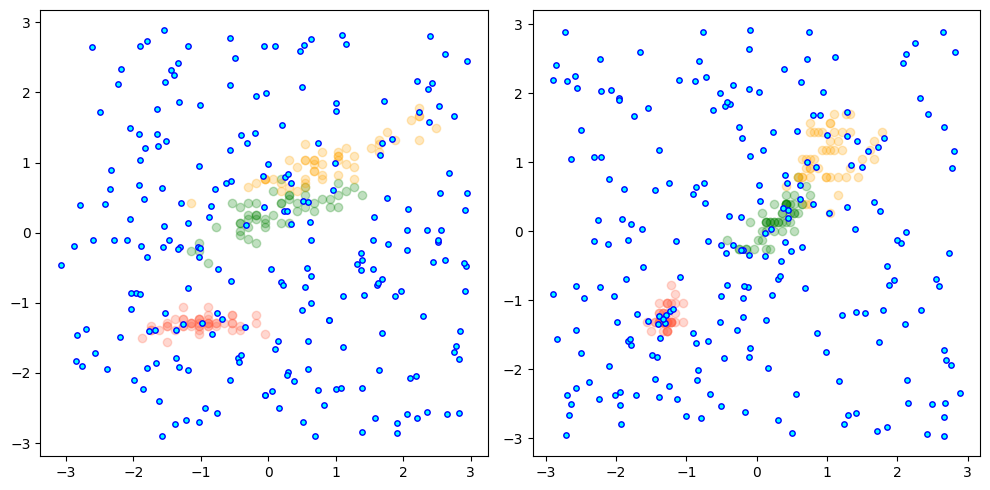

In [260]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_dpi(100)
fig.set_figwidth(10)
fig.set_figheight(5)

axs[0].scatter(data[0:50, 0], data[0:50, 2], c='tomato', alpha=0.25)
axs[0].scatter(data[50:100, 0], data[50:100, 2], c='green', alpha=0.25)
axs[0].scatter(data[100:150, 0], data[100:150, 2], c='orange', alpha=0.25)

axs[0].scatter(model.p[:, 0], model.p[:, 2], s=15,
                 c='cyan', edgecolors='blue')

axs[1].scatter(data[0:50, 2], data[0:50, 3], c='tomato', alpha=0.25)
axs[1].scatter(data[50:100, 2], data[50:100, 3], c='green', alpha=0.25)
axs[1].scatter(data[100:150, 2], data[100:150, 3], c='orange', alpha=0.25)

axs[1].scatter(model.p[:, 2], model.p[:, 3], s=15,
                  c='cyan', edgecolors='blue')

plt.tight_layout()
plt.autoscale()
plt.show()

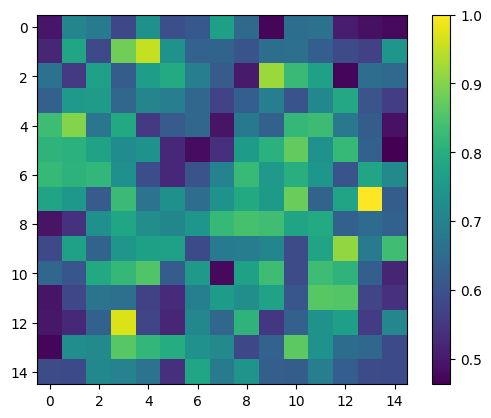

In [261]:
m = int(math.sqrt(n))

p = model.p.copy()

idxy = np.array(range(n)).reshape((m, m))
nidxy = np.zeros((m, m)).tolist()

nrange = 1
for i in range(m):
    for j in range(m):
        from_row, to_row = max(0, i-nrange), min(m, i+nrange+1)
        from_col, to_col = max(0, j-nrange), min(m, j+nrange+1)
        nidxy[i][j] = idxy[from_row:to_row, from_col:to_col].ravel().tolist()

dmtrx = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        idx = m*i+j

        ndist = np.mean([np.linalg.norm(p[idx]-p[k])
                         for k in nidxy[i][j]])
        dmtrx[i, j] = ndist

img = plt.imshow(dmtrx/np.max(dmtrx), cmap='viridis', interpolation='none')
plt.colorbar(img)
plt.show()

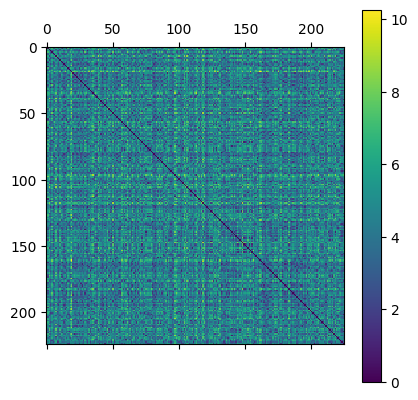

In [262]:
distances = np.array(
    [[np.linalg.norm(a-b) for b in model.p] for a in model.p]
)

img = plt.matshow(distances)
plt.colorbar(img)
plt.show()

[-0.89767388  1.02861128 -1.33679402 -1.30859282]


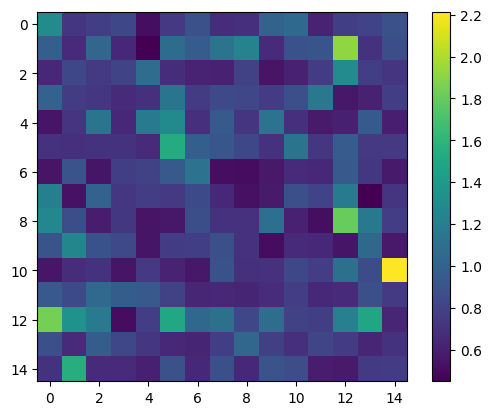

[-0.17309407  3.10428427 -1.28011819 -1.04652483]


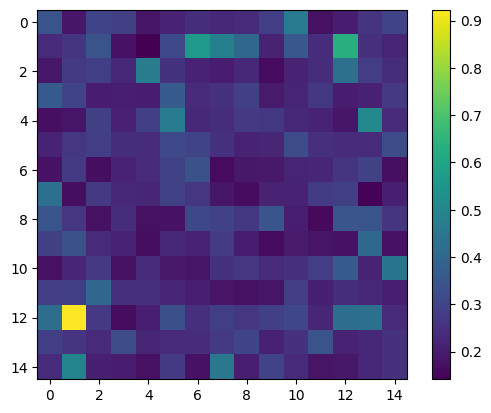

[-1.25996379  0.10608995 -1.22344235 -1.30859282]


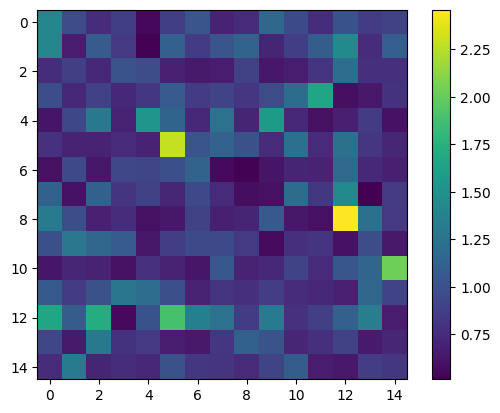

[-1.25996379 -0.12454038 -1.33679402 -1.17755883]


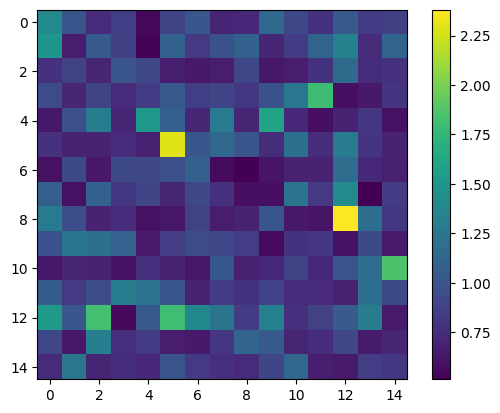

[-1.01843718 -2.4308437  -0.14660149 -0.26032087]


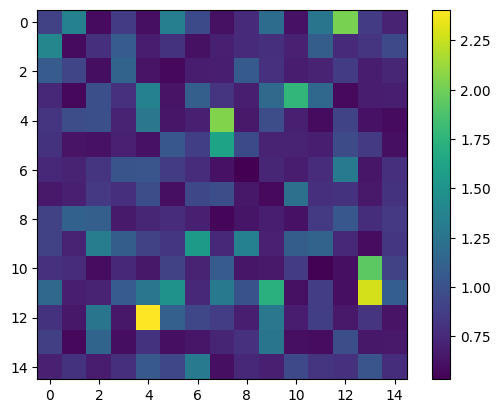

[ 0.91377565 -0.12454038  0.36348102  0.26381511]


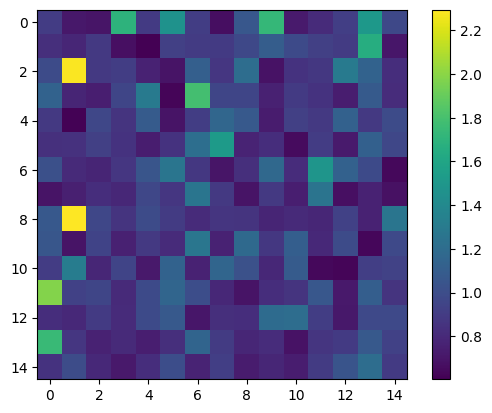

[-0.41462067 -1.04706171  0.36348102  0.00174712]


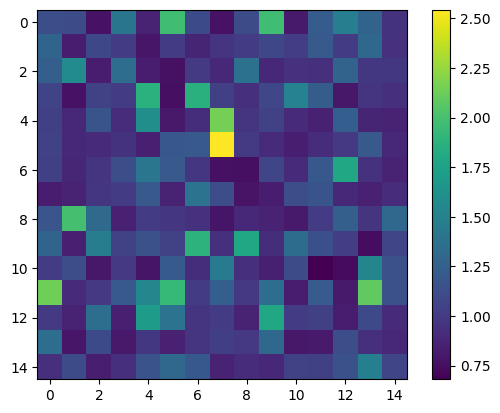

[ 2.12140867 -0.12454038  1.61034938  1.18105307]


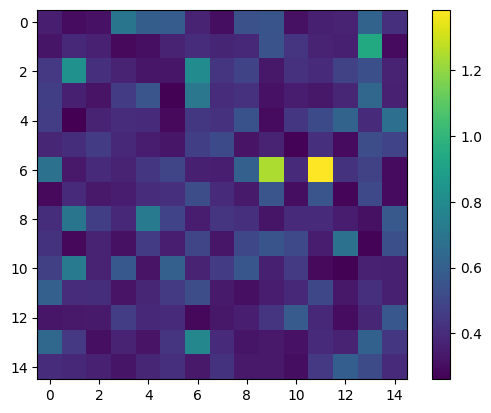

[1.27606556 0.33672028 1.10026687 1.44312105]


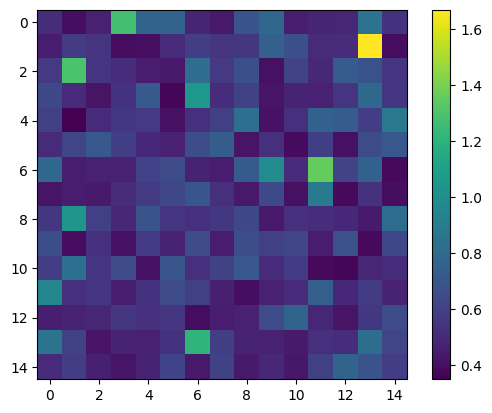

[ 2.24217198 -0.12454038  1.32697021  1.44312105]


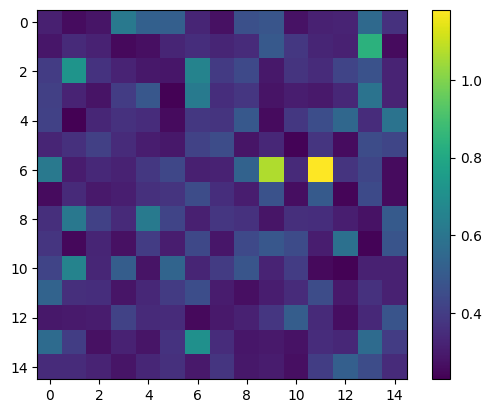

In [263]:
y = []
for x in data[::15]:
    a = np.exp(-np.sum(np.square(x-model.p), axis=1))
    # a = np.sqrt(np.sum(np.square(x-model.p), axis=1))
    y = np.dot(1/(distances+1), a)
    

    print(x)

    img = plt.imshow(y.reshape((m, m)))
    plt.colorbar(img)
    plt.show()

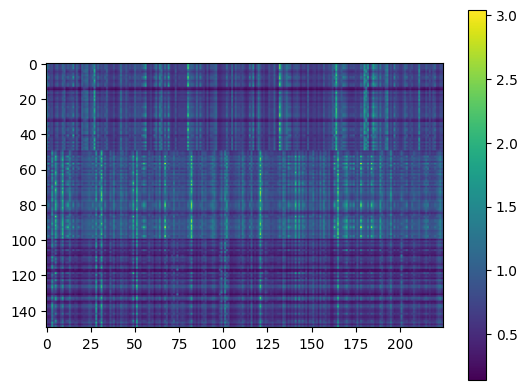

In [264]:
y = []
for x in data:
    a = np.exp(-np.sum(np.square(x-model.p), axis=1))
    # a = np.sqrt(np.sum(np.square(x-model.p), axis=1))
    y.append(np.dot(1/(distances+1), a))
    

img = plt.imshow(y)
plt.colorbar(img)
plt.show()